Imports and final vars declaration

In [39]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from common.parser_utils import ParserUtils
from common.data_frame_utils import DataFrameUtils
from common.data_visualization import DataVisualization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from pandas.plotting import register_matplotlib_converters
# from pylab import rcParams
from sklearn.metrics import confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# rcParams['figure.figsize'] = 11, 5

# RANDOM_SEED = 3

# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)


Obtain data

In [40]:
full_df = ParserUtils.get_full_dataframe_without_error_previous_data(None, None, None, 4000)

train_df, test_df = DataFrameUtils.train_test_split(full_df, 0.2)


Process data - Normalization

In [41]:
test_ok = DataFrameUtils.get_test_ok_dataframe_as_preprocessed_np_array(test_df)
test_error = DataFrameUtils.get_test_error_dataframe_as_preprocessed_np_array(test_df)
train = DataFrameUtils.get_train_dataframe_as_preprocessed_np_array(train_df)
test, test_state = DataFrameUtils.get_test_mixed_dataframe_as_preprocessed_np_array(test_df)

Autoencoder architecture

In [42]:
# Autoencoder creation
# define input shape
input_dim = train.shape[1]
input_obj = Input(shape=(input_dim))

# encoder level 1
e = Dense(input_dim*2)(input_obj)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(input_dim*1.5)(e)
e = LeakyReLU()(e)
e = Dropout(0.1)(e)
# encoder level 3
e = Dense(input_dim)(e)
e = LeakyReLU()(e)
# encoder level 4
e = Dense(input_dim/1.5)(e)
e = LeakyReLU()(e)
e = Dropout(0.1)(e)
# encoder level 5
e = Dense(input_dim/2)(e)
e = LeakyReLU()(e)
# bottleneck
bottleneck = Dense(4)(e)
bottleneck = LeakyReLU()(bottleneck)

# define decoder, level 1
d = Dense(input_dim/2)(bottleneck)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(input_dim/1.5)(d)
d = LeakyReLU()(d)
e = Dropout(0.1)(e)
# decoder level 3
d = Dense(input_dim)(d)
d = LeakyReLU()(d)
# decoder level 4
d = Dense(input_dim*1.5)(d)
d = LeakyReLU()(d)
e = Dropout(0.1)(e)
# decoder level 5
d = Dense(input_dim*2)(d)
d = LeakyReLU()(d)
# output layer
output = Dense(input_dim, activation='sigmoid')(d)

# Autoencoder
autoencoder = Model(inputs=input_obj, outputs=output)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_24 (Dense)            (None, 24)                312       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 24)                0         
                                                                 
 dense_25 (Dense)            (None, 18)                450       
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 18)                0         
                                                                 
 dropout_8 (Dropout)         (None, 18)                0         
                                                                 
 dense_26 (Dense)            (None, 12)                228 

Autoencoder training

In [43]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    train,
    train,
    epochs=10,
    batch_size=200,
    validation_data=(test_ok, test_ok),
    shuffle=False
)

Epoch 1/10
787/787 [==============================] - 2s 3ms/step - loss: 0.0256 - val_loss: 0.0016
Epoch 2/10
787/787 [==============================] - 2s 3ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/10
787/787 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/10
787/787 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/10
787/787 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 8.8237e-04
Epoch 6/10
787/787 [==============================] - 2s 2ms/step - loss: 0.0010 - val_loss: 7.1954e-04
Epoch 7/10
787/787 [==============================] - 2s 3ms/step - loss: 8.7769e-04 - val_loss: 6.5224e-04
Epoch 8/10
787/787 [==============================] - 2s 2ms/step - loss: 8.0975e-04 - val_loss: 6.2749e-04
Epoch 9/10
787/787 [==============================] - 2s 2ms/step - loss: 7.5676e-04 - val_loss: 6.1269e-04
Epoch 10/10
787/787 [==============================] - 2s 2ms/step -

Autoencoder validation

Graph showing loss through training - should be 0


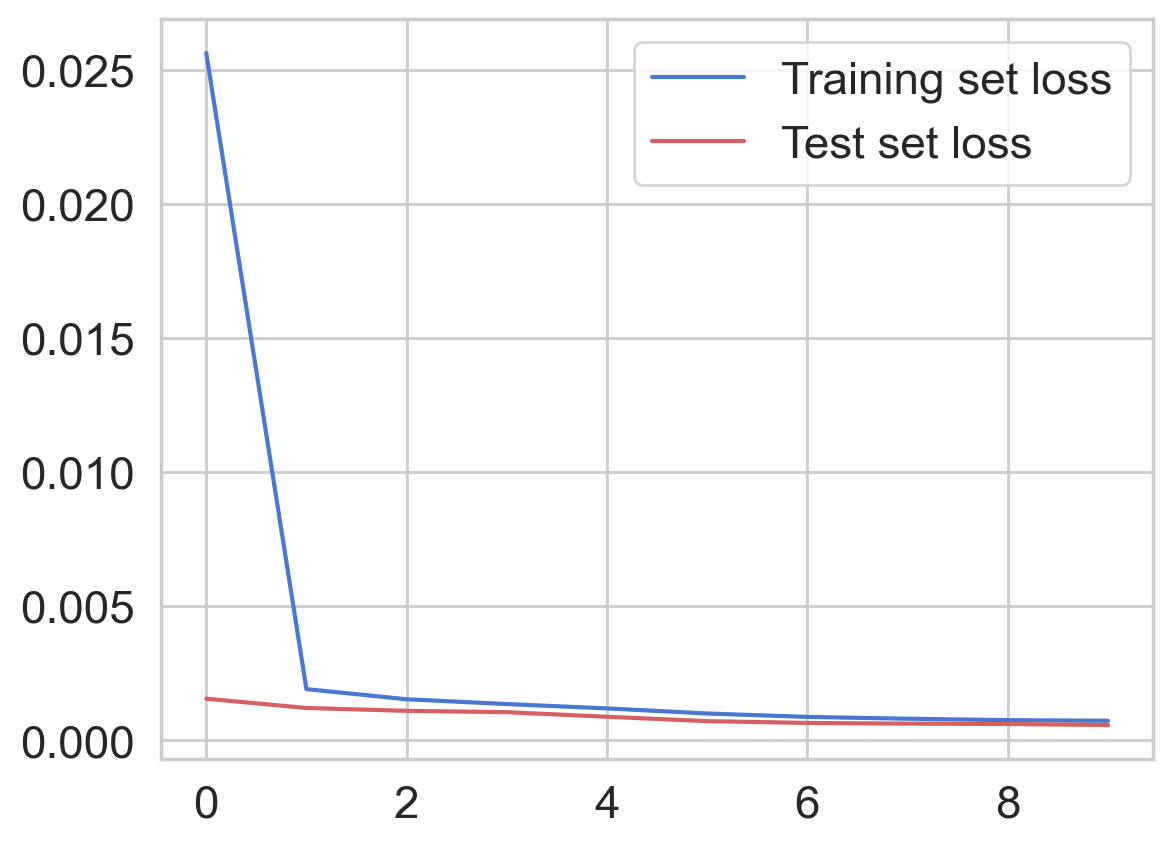

In [44]:
DataVisualization.training_test_loss(history)


Graph representation of normal data and anormal data


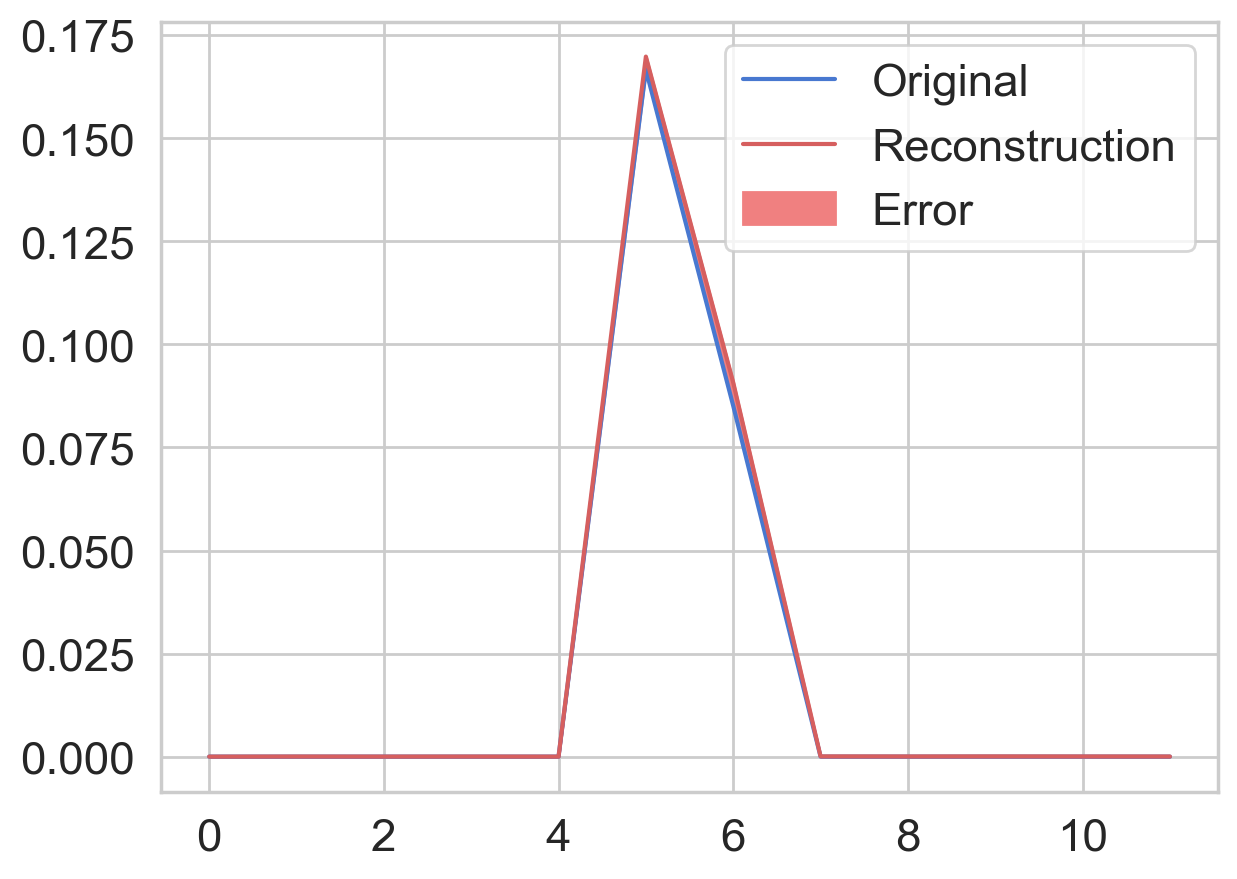

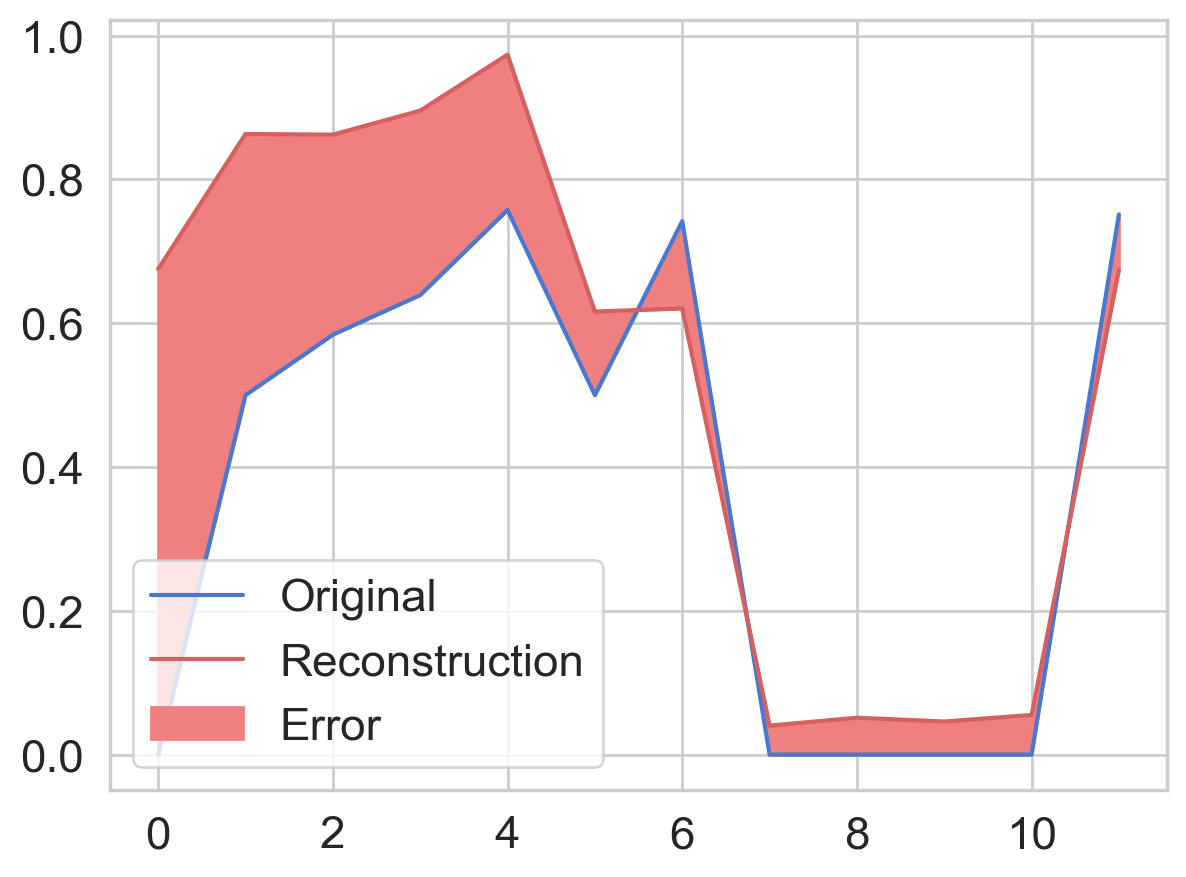

In [45]:
test_ok_pred = autoencoder(test_ok).numpy()
test_error_pred = autoencoder(test_error).numpy()

sample_position = 25

DataVisualization.data_reconstruction(test_ok, test_ok_pred, sample_position, test_ok.shape[1])

DataVisualization.data_reconstruction(test_error, test_error_pred, sample_position, test_error.shape[1])

Threshold


In [46]:
test_pred = autoencoder(test).numpy()
loss = tf.keras.losses.mse(test_pred, test)

threshold = np.mean(loss) + np.std(loss)
print("Threshold: ", threshold)

Threshold:  0.0064140581698837245


Confusion matrix





In [47]:
test_pred = autoencoder.predict(test)
mse = np.mean(np.power(test - test_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
'True_class': test_state})
error_df.describe()

1262/1262 [==============================] - 1s 831us/step


,Reconstruction_error
count,40364.000000
mean,0.001262
std,0.005154
min,0.000003
25%,0.000020
50%,0.000161
75%,0.000631
max,0.060824


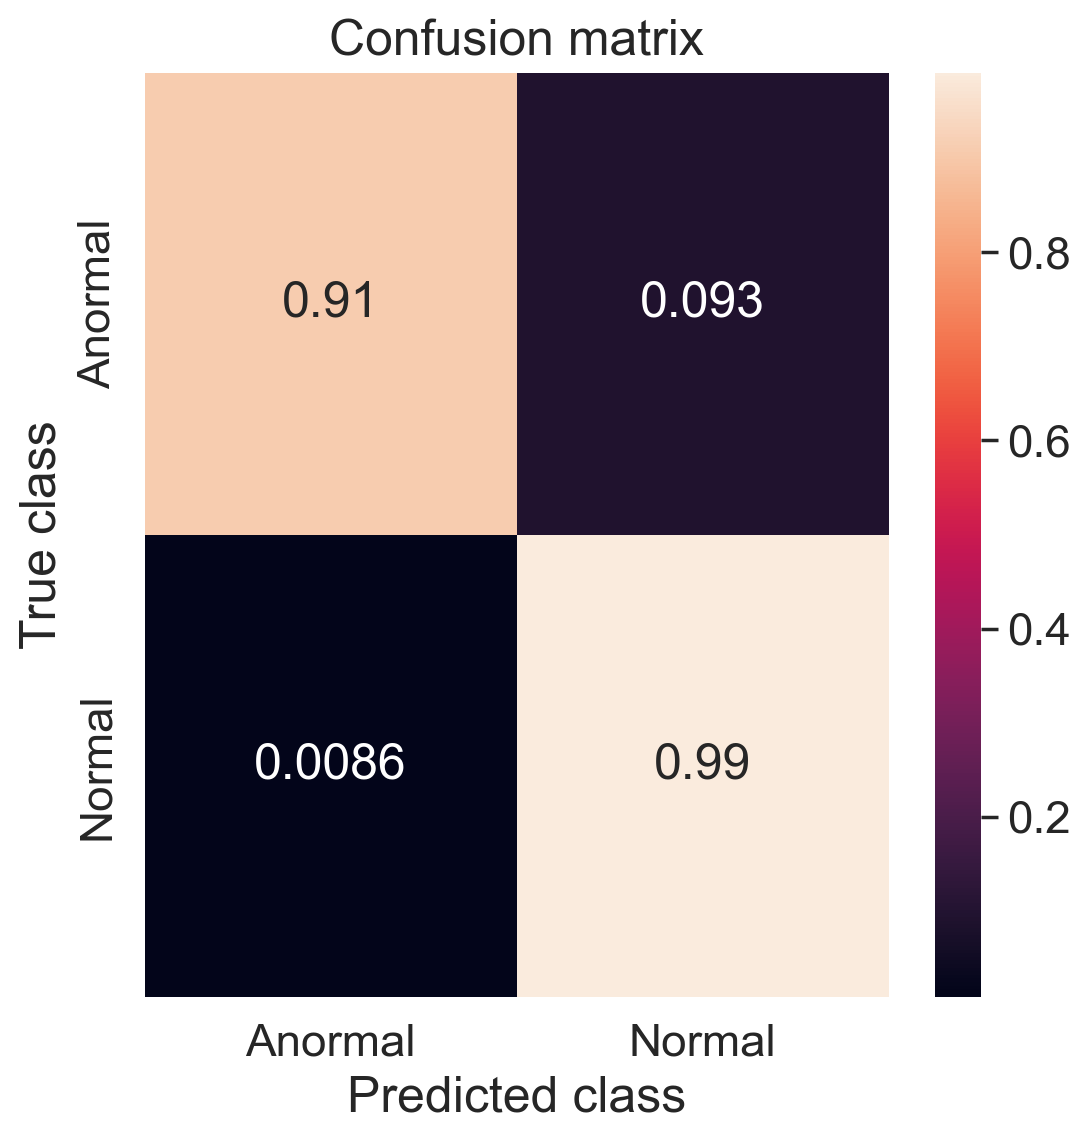

In [48]:
LABELS = ['Anormal', 'Normal']

pred_state = [0 if e > threshold else 1 for e in error_df.Reconstruction_error.values]
test_state_formatted = [1 if e == 1 else 0 for e in error_df.True_class.values]

result = confusion_matrix(test_state_formatted, pred_state, normalize='true')

plt.figure(figsize=(6, 6))
sns.heatmap(result, xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



Graph nº samples / losses

33/33 [==============================] - 0s 837us/step


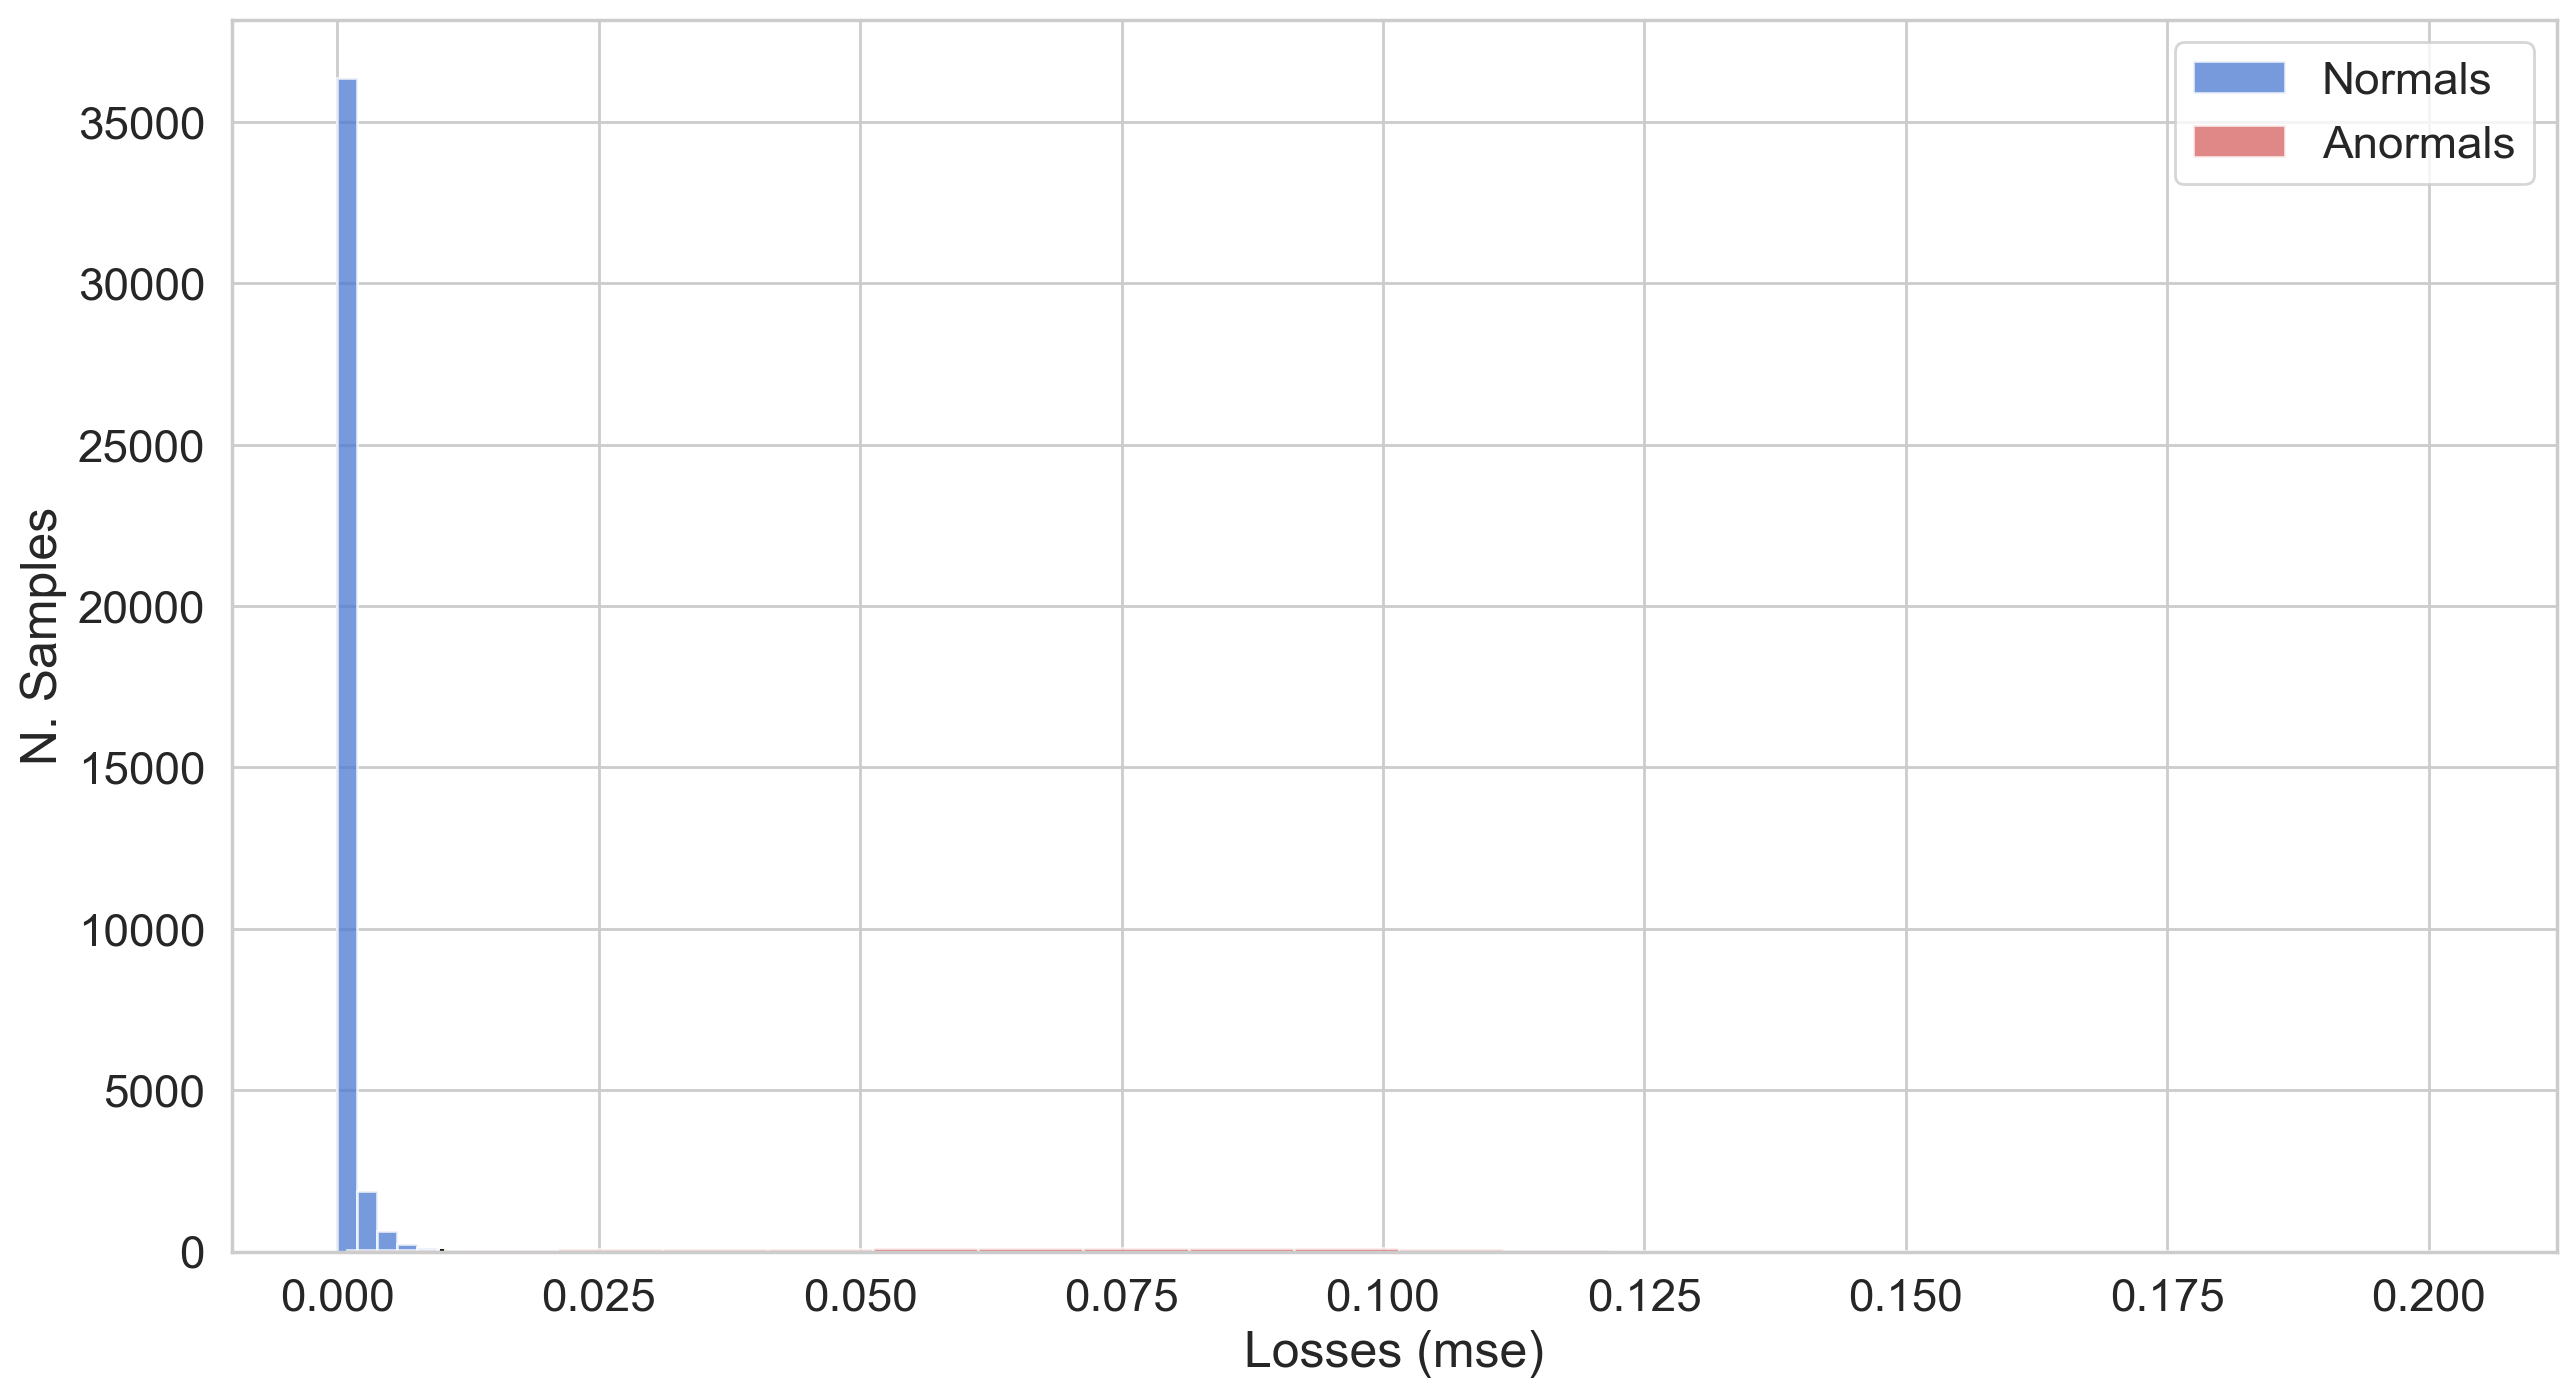

In [49]:
pred_ok = autoencoder.predict(test_ok)
pred_error = autoencoder.predict(test_error)

# Error medio entre reconstruccion y datos reales
loss_ok = tf.keras.losses.mse(pred_ok, test_ok)
loss_error = tf.keras.losses.mse(pred_error, test_error)

plt.figure(figsize=(15,8))
plt.hist(loss_ok[None,:], bins=20, alpha=0.75, label='Normals')
plt.hist(loss_error[None,:], bins=20, alpha=0.75, color='r', label='Anormals')
plt.xlabel('Losses (mse)')
plt.ylabel('N. Samples')
plt.legend(loc='upper right')
plt.vlines(0.01,0,70,'k')

Graph showing data reproduction and anormal data marked using threshold

Inversor 1 - 15/05/2021 (12786 - 13025)

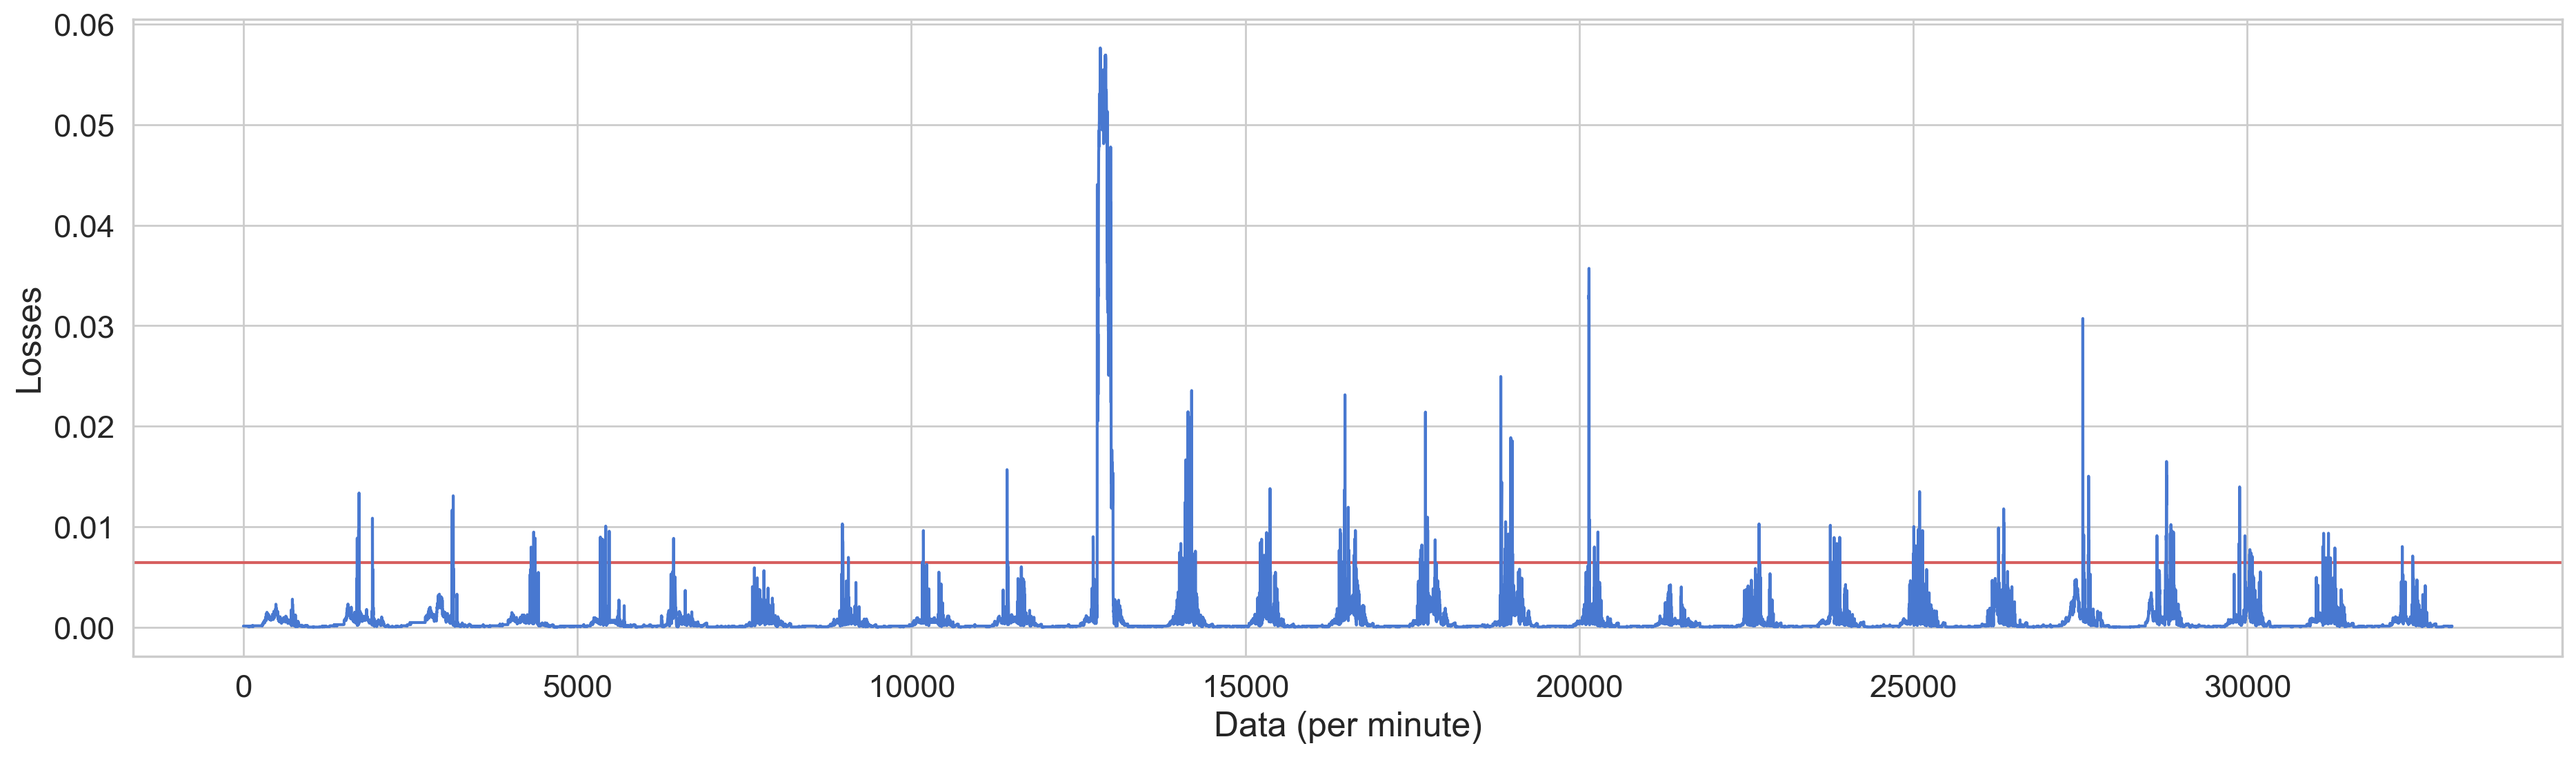

In [50]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_1_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)

Inversor 7 - 11/03/2021 (12876 - 13219)

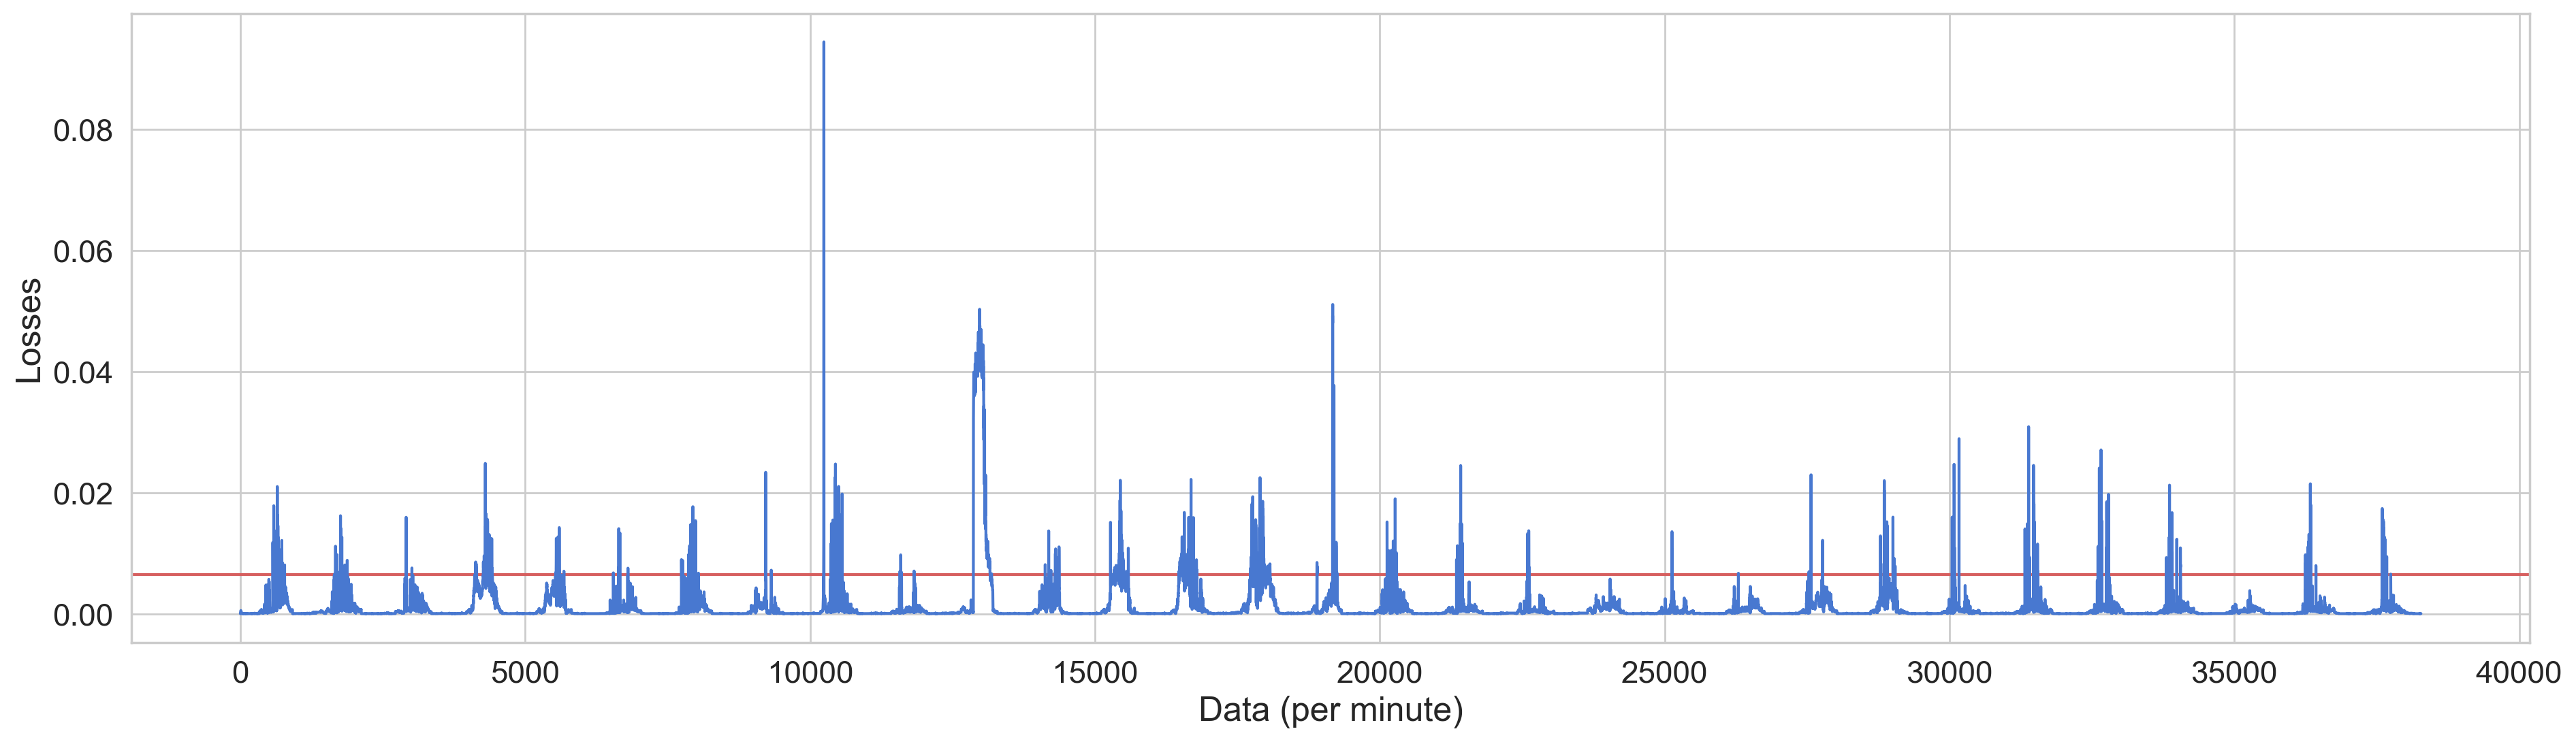

In [51]:
full_df = ParserUtils.get_full_dataframe(7, 3, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_3.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)

Inversor 7 - 17/04/2021 (20592 - 20764)

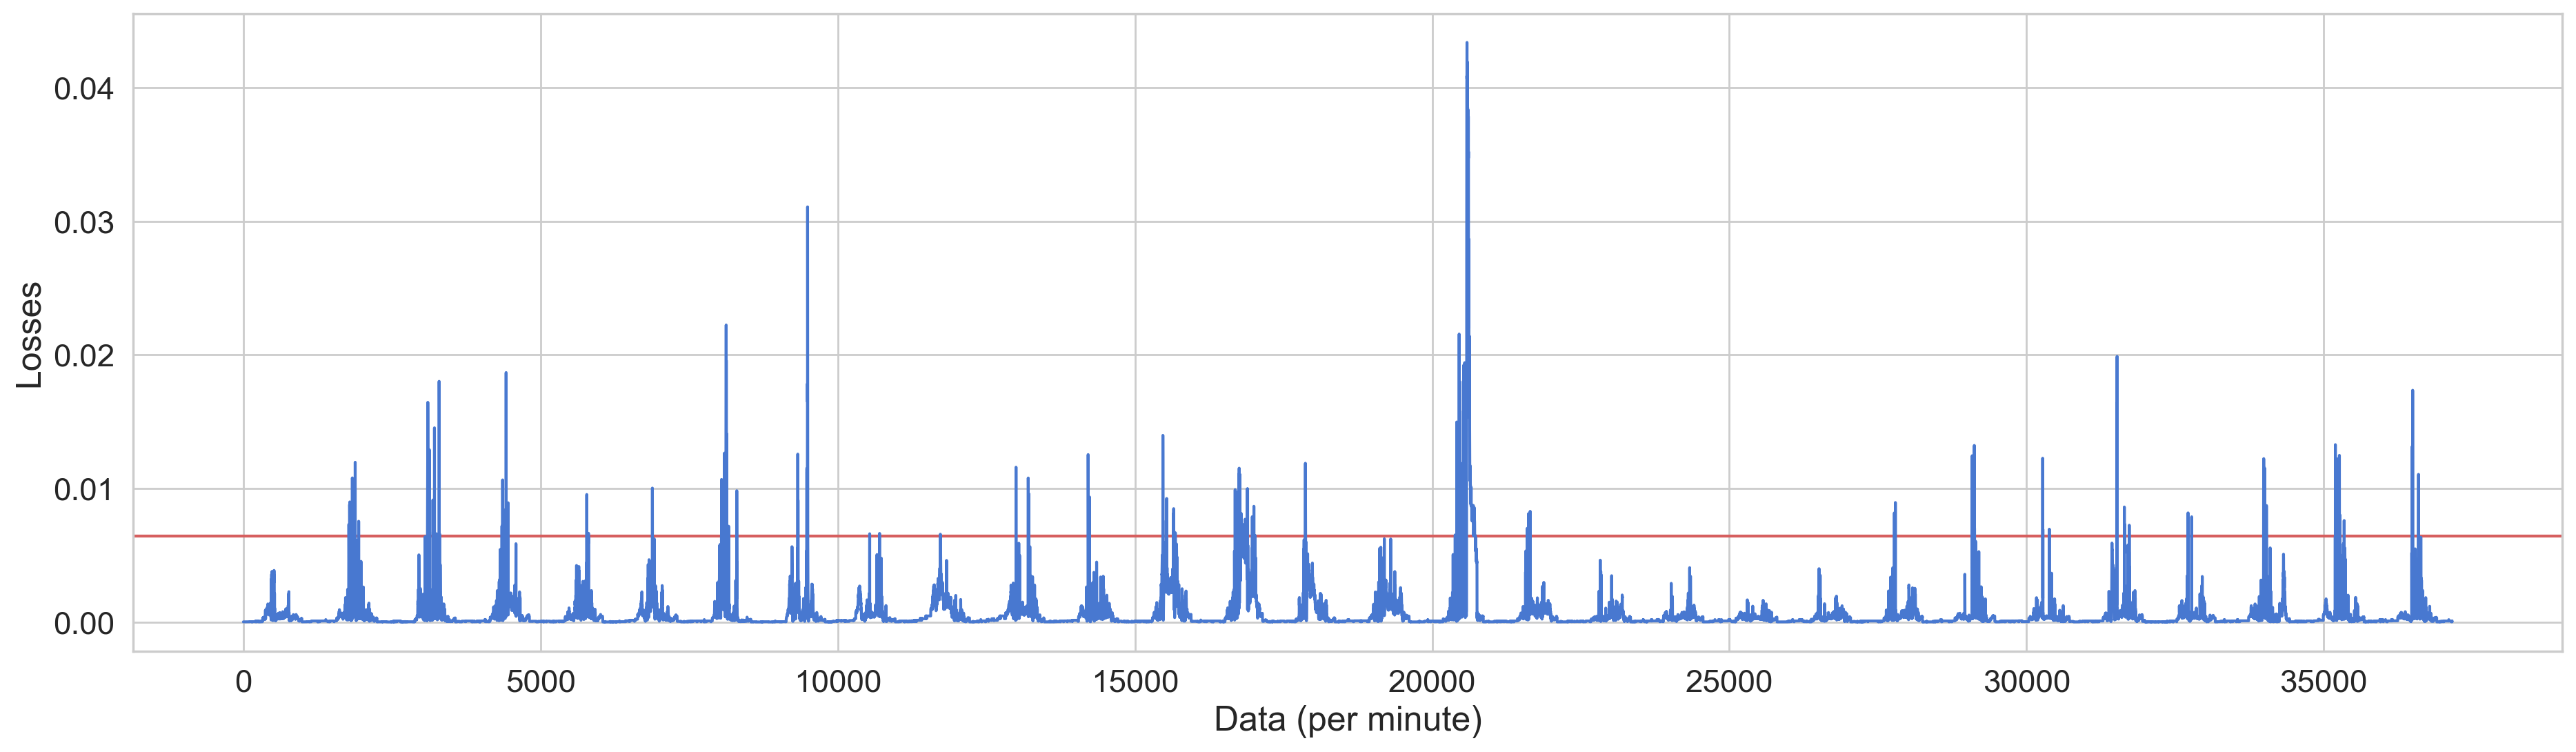

In [52]:
full_df = ParserUtils.get_full_dataframe(7, 4, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_4.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)

Inversor 7 - 15/05/2021 (12760 - 13056) + 21/05/2021 (20086 - 20325)

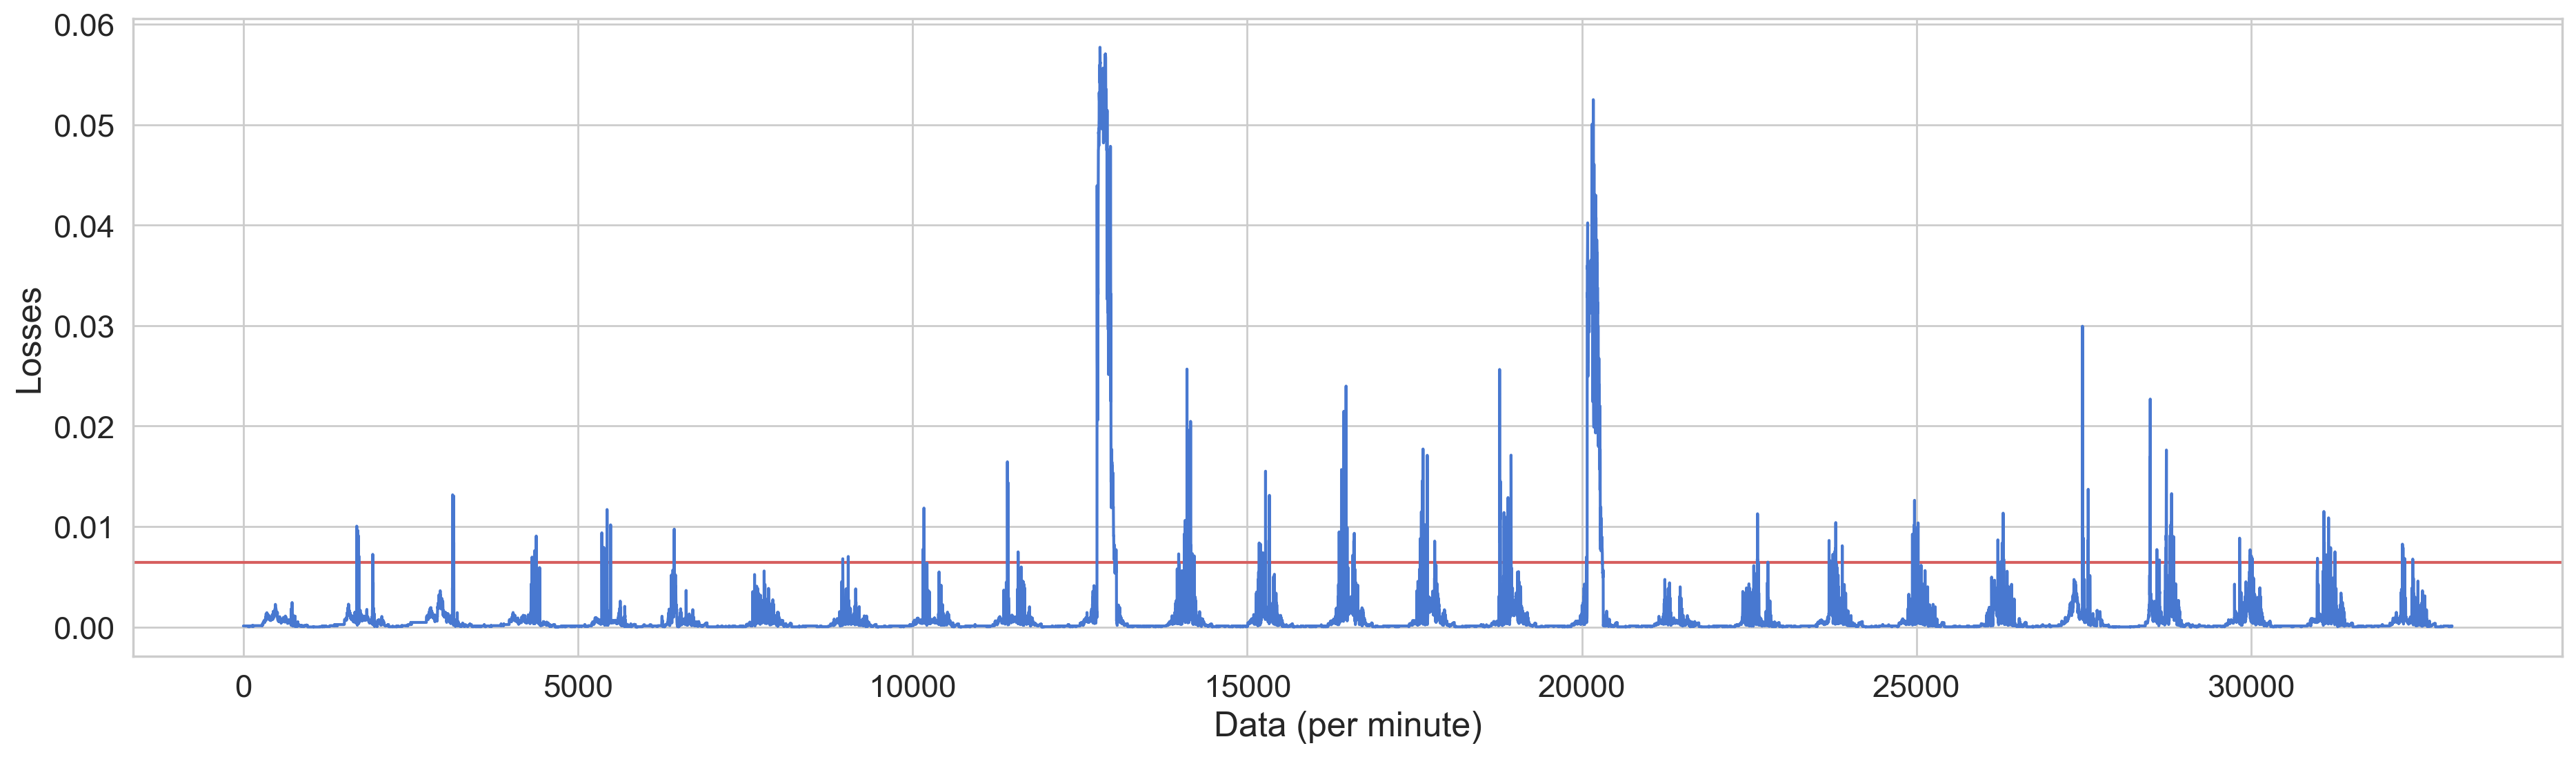

In [53]:
full_df = ParserUtils.get_full_dataframe(7, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)

Save model if has good results

In [54]:
autoencoder.save('autoencoder2.h5')

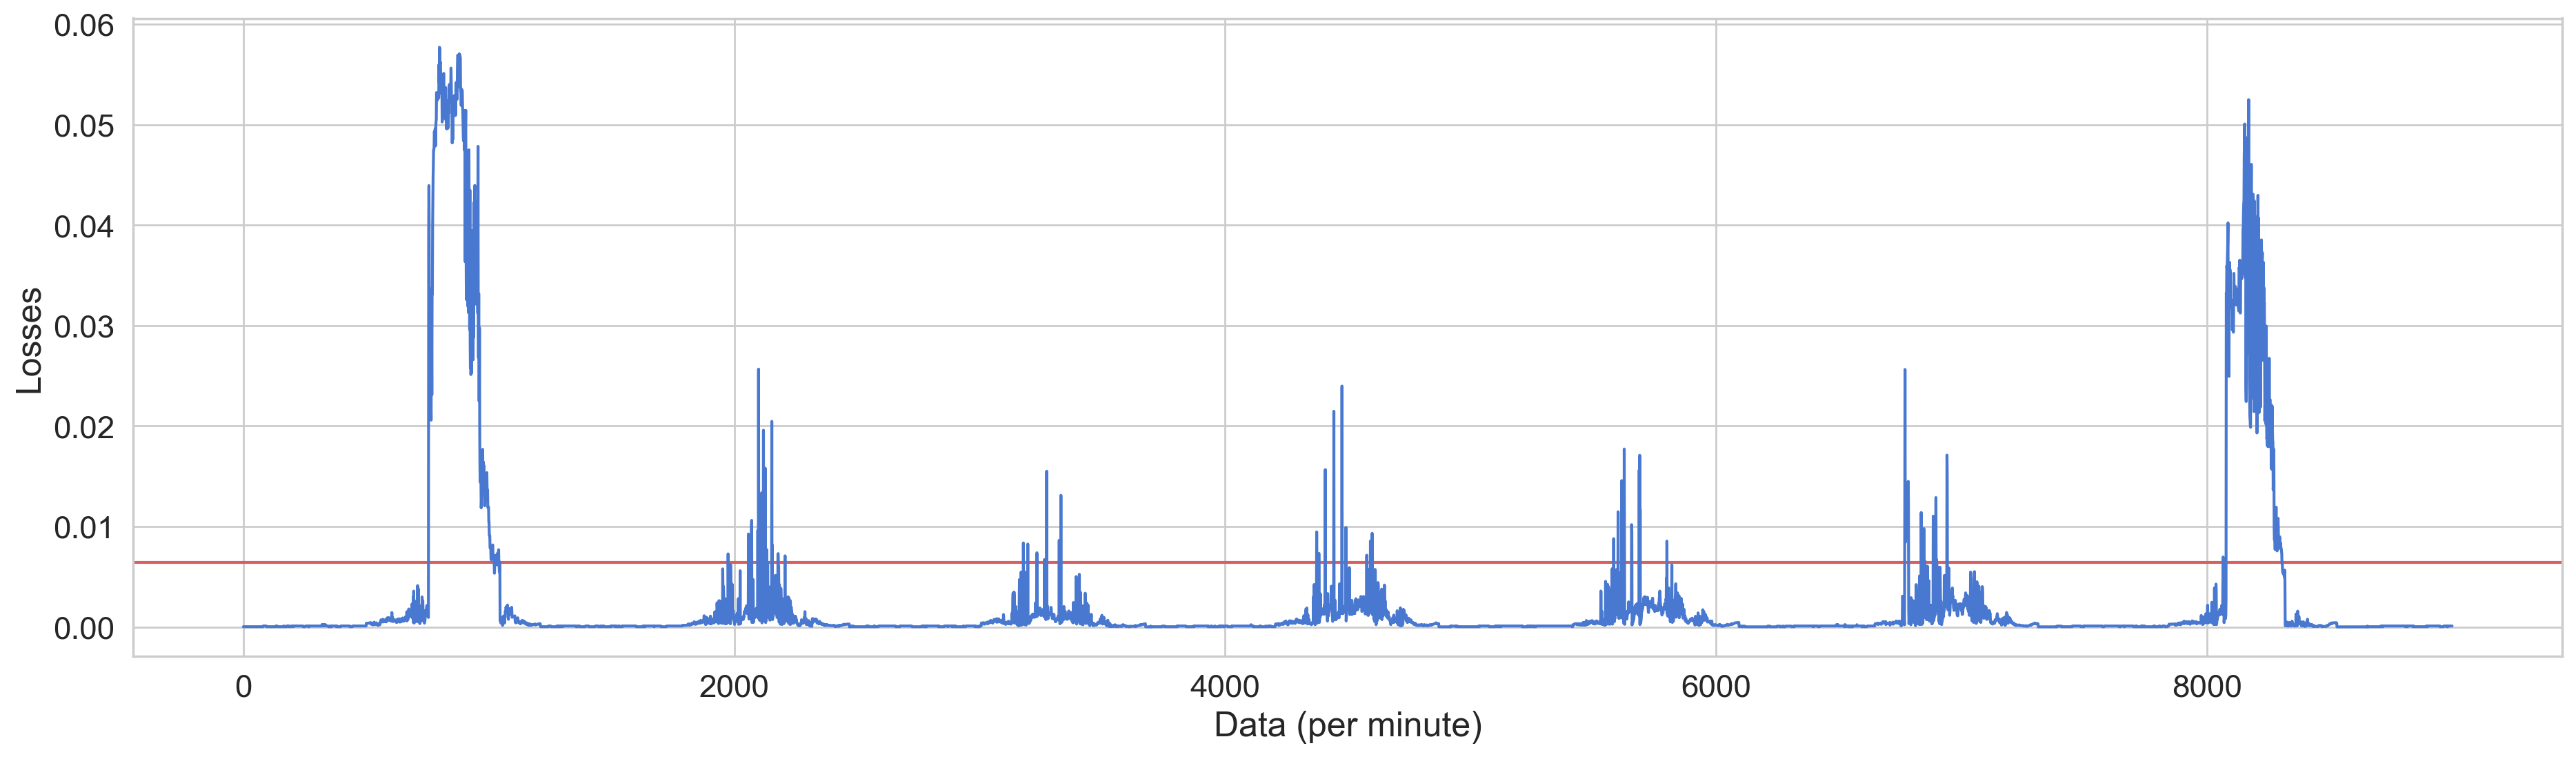

In [55]:
full_df = ParserUtils.get_full_dataframe(7, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses[12000: 21000]
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)

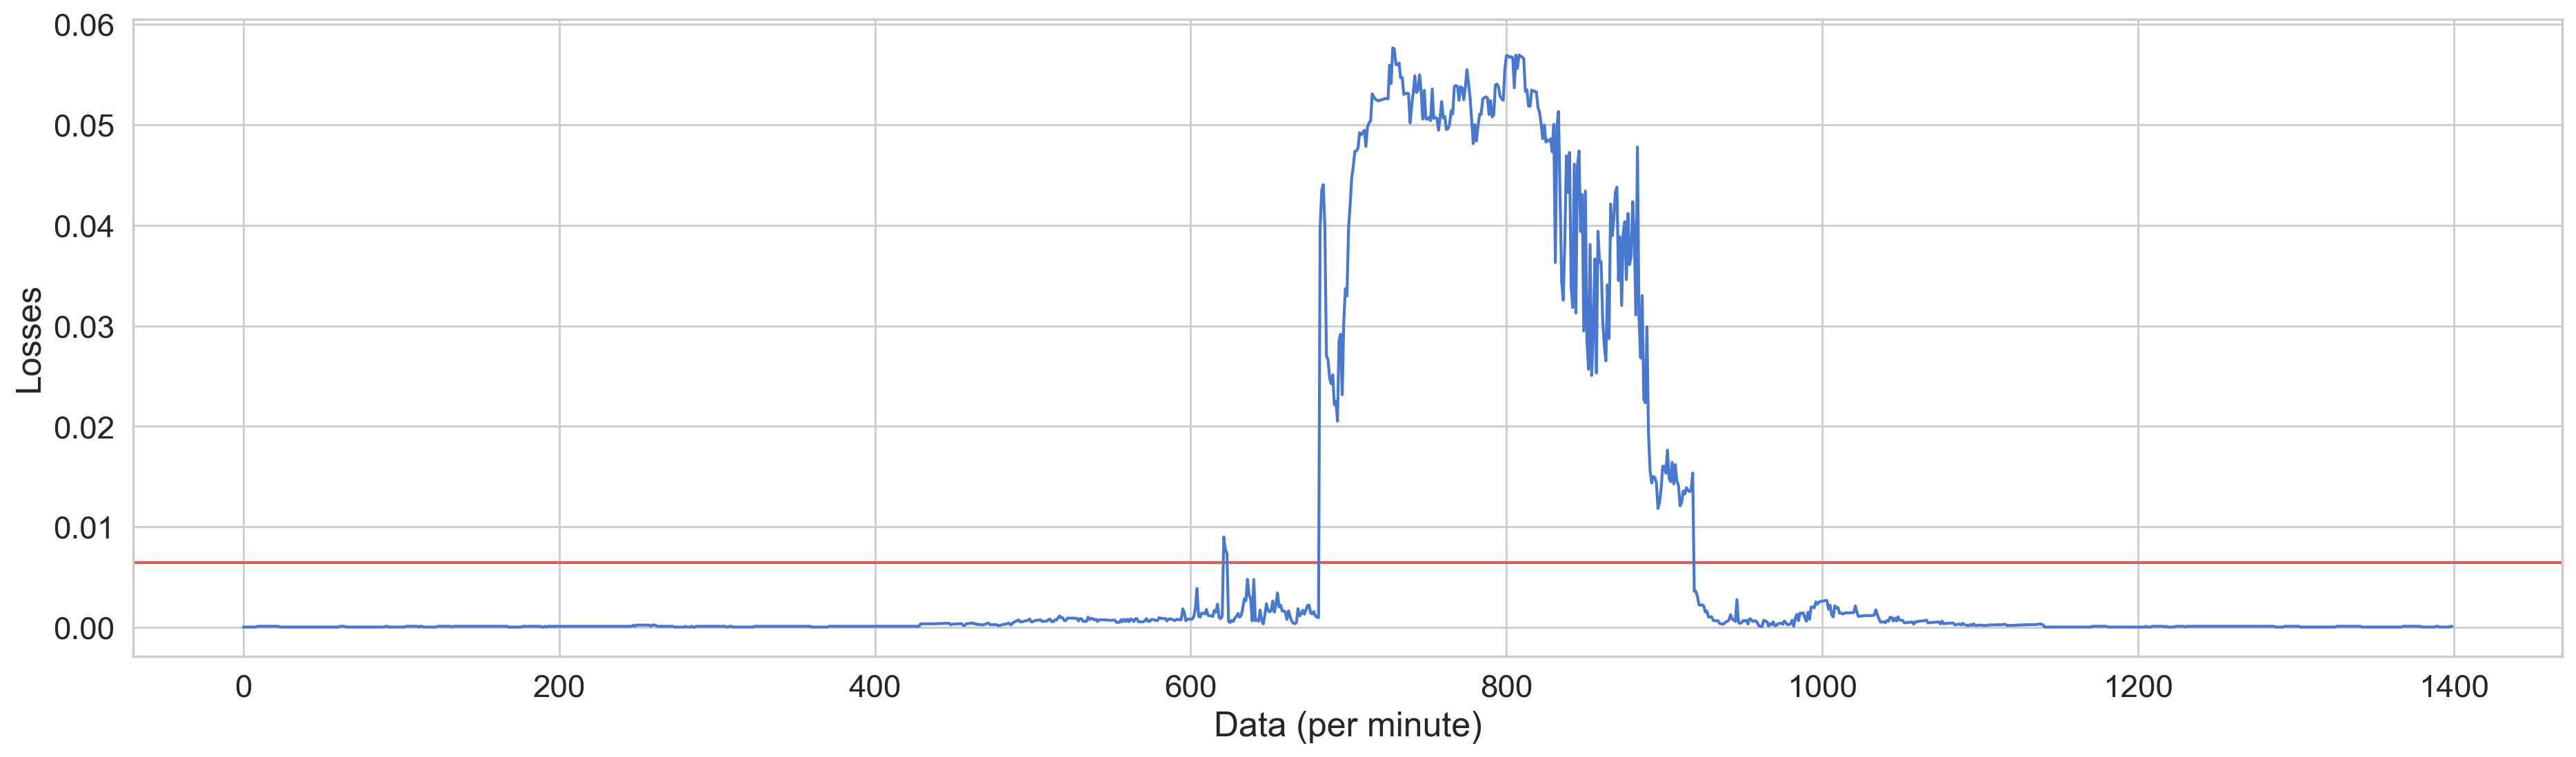

In [56]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_1_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses[12100 : 13500]
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)

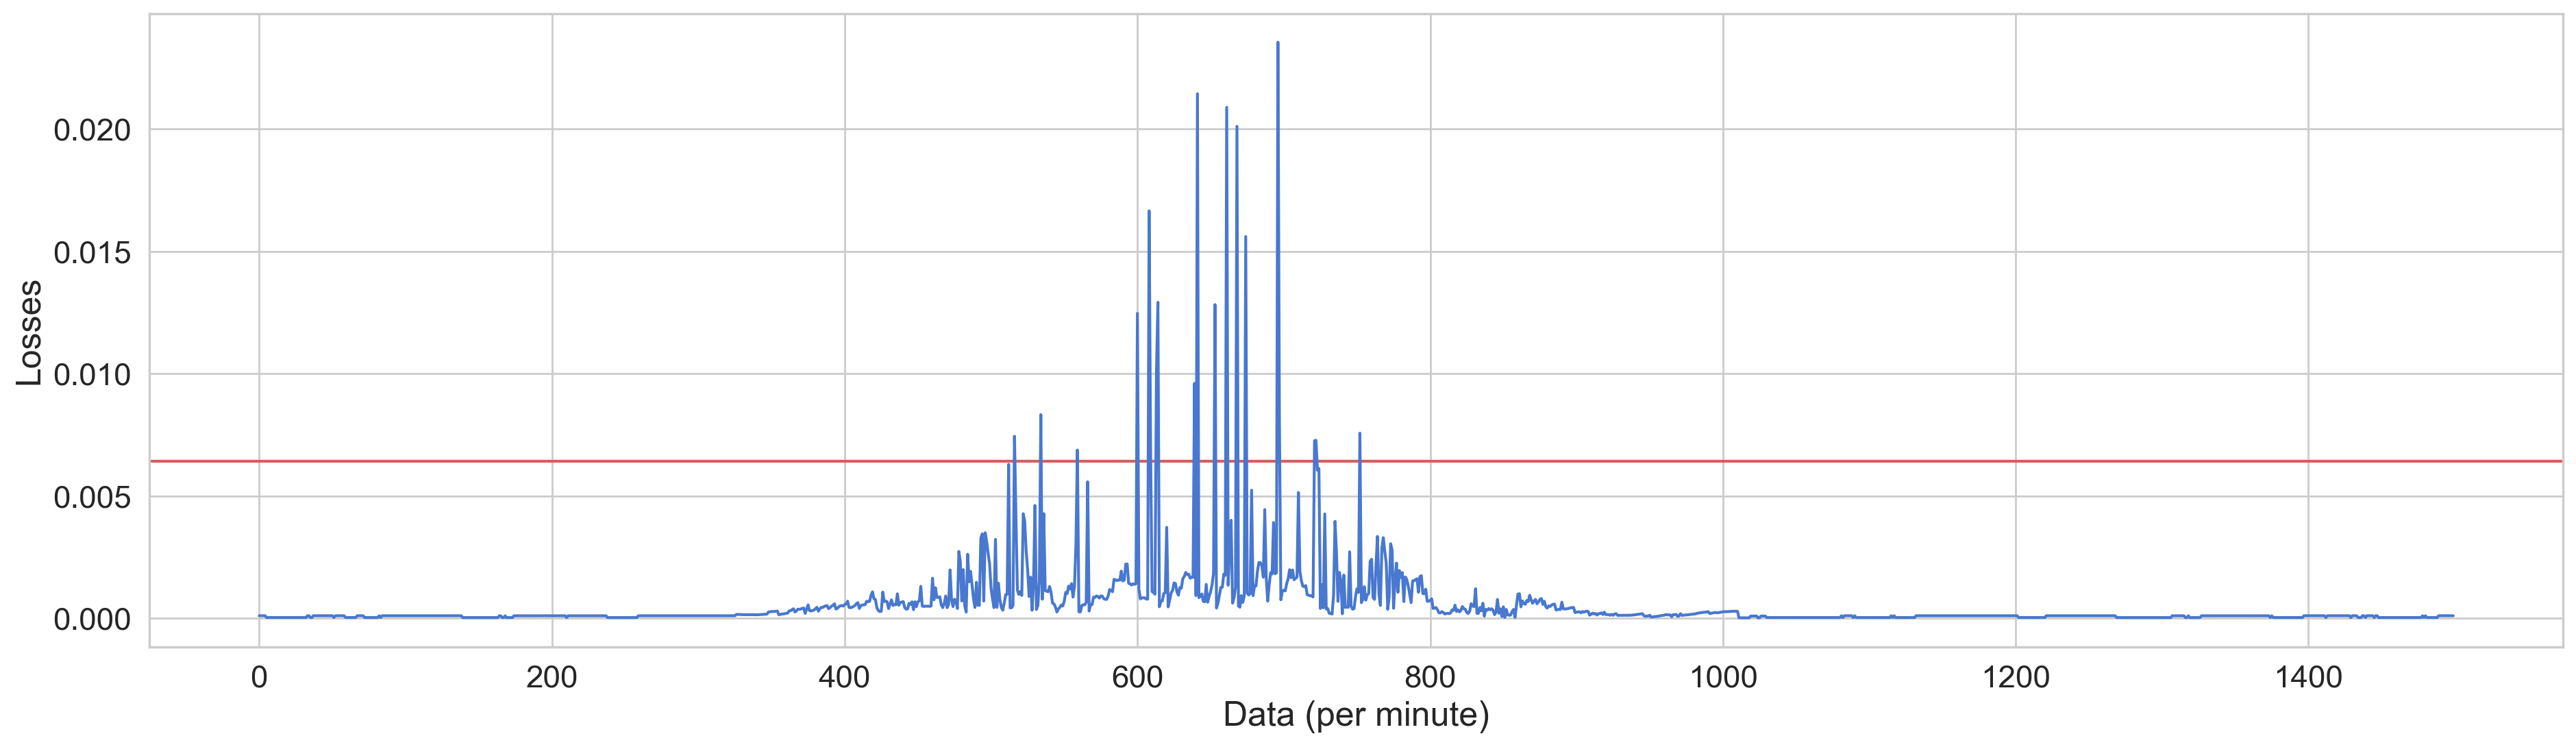

In [57]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_1_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

# Data set clean, predict and get error
losses = tf.keras.losses.mse(autoencoder(main_test_norm), main_test_norm)
losses = losses[13500 : 15000]
losses = losses.numpy()

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='r', linestyle='-')
plt.ylabel('Losses')
plt.xlabel('Data (per minute)')
plt.plot(np.arange(losses.size), losses)